## Flight routes: rendering large(ish) graphs

This example covers:
- rendering graphs that exceed the default Altair 5000-item dataset limit
- versatility of the "pos" data structure (`{node_id: (x,y)}`) used for layouts, which can
  come from geolocation lat-long coordinates just as easily as from a computed layout.
- a couple of techniques for pruning dense, hard-to-interpret graphs
- other tips for rendering large graphs

The dataset comes from [OpenFlights](https://openflights.org/data.html), includes flight routes 
from across the globe as captured in 2014, along with airport data. It is also available
[on Kaggle](https://www.kaggle.com/code/divyanshrai/airport-route-analysis).

In [1]:
import os
import sys
import altair as alt
import networkx as nx
import numpy as np
import pandas as pd
from IPython.display import display

".." in sys.path or sys.path.append("..")
from alph import alph, layout, util

util.set_altair_renderer()

### 1. Prepare large chart rendering

In [2]:
# Pick a different appraoch for large Altair graphs if you like
# https://altair-viz.github.io/user_guide/faq.html#maxrowserror-how-can-i-plot-large-datasets
# https://altair-viz.github.io/user_guide/data_transformers.html#storing-json-data-in-a-separate-directory

def chart_data_dir(data, data_dir='out'):
    os.makedirs(data_dir, exist_ok=True)
    return alt.to_json(data, filename=data_dir + "/{prefix}-{hash}.{extension}")


alt.data_transformers.register("chart_data_dir", chart_data_dir)
alt.data_transformers.enable("chart_data_dir")

DataTransformerRegistry.enable('chart_data_dir')

### 2. Fetch and preprocess data

In [13]:
routes_url = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat"
airports_url = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat"

airports_cols = [
    x.lower().replace(" ", "_")
    for x in [
        "Airport ID", "Name", "City", "Country", "IATA",
        "ICAO", "Latitude", "Longitude", "Altitude", 
        "Timezone", "DST", "Tz database time zone", "Type", "Source",
    ]
]
routes_cols = [
    x.lower().replace(" ", "_")
    for x in [
        "Airline", "Airline ID",
        "Source airport", "Source airport ID",
        "Destination airport", "Destination airport ID",
        "Codeshare", "Stops", "Equipment"
    ]
]

airports = pd.read_csv(airports_url, names=airports_cols)

routes = pd.read_csv(routes_url, names=routes_cols).pipe(
    lambda d: d[
        (d["source_airport_id"] != "\\N") & (d["destination_airport_id"] != "\\N")
    ]
).astype({
    "source_airport_id": int,
    "destination_airport_id": int,
}).pipe(
    lambda d: d[
        (d["source_airport_id"].isin(airports["airport_id"])) & (d["destination_airport_id"].isin(airports["airport_id"]))
    ]
)

print(f"{airports.shape[0]} airport(s), {routes.shape[0]} route(s)")
display(routes.head(2))
display(airports.head(2))

7698 airport(s), 66771 route(s)


,airline,airline_id,source_airport,source_airport_id,destination_airport,destination_airport_id,codeshare,stops,equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2


,airport_id,name,city,country,iata,icao,latitude,longitude,altitude,timezone,dst,tz_database_time_zone,type,source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.08169,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.20708,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports


In [14]:
route_edges = (
    routes
    .assign(
        a_id=lambda d: np.where(
            d["source_airport_id"] <= d["destination_airport_id"], d["source_airport_id"], d["destination_airport_id"]
        ),
        b_id=lambda d: np.where(
            d["source_airport_id"] <= d["destination_airport_id"], d["destination_airport_id"], d["source_airport_id"]
        ),
    )
    .pipe(lambda d: d[d["a_id"] != d["b_id"]])
    .groupby(["a_id", "b_id"])
    ["airline_id"].count()
    .rename("weight")    
    .reset_index()
).assign(
    weight_norm=lambda d: d["weight"] / d["weight"].max(),
)

print(f"{len(route_edges)} unique undirected route(s)")
route_edges.sort_values(by="weight", ascending=False).head()

18858 unique undirected route(s)


,a_id,b_id,weight,weight_norm
17137,3682,3830,39,1.000000
12958,3077,3885,24,0.615385
16444,3576,3682,24,0.615385
3623,507,3797,24,0.615385
13247,3179,3885,23,0.589744


In [15]:
airports_by_id = airports[[
    "airport_id", "name", "city", "country", "iata", "icao"
]].set_index("airport_id").to_dict("index")

G = nx.from_pandas_edgelist(route_edges, source="a_id", target="b_id", edge_attr="weight")
nx.set_node_attributes(G, {n: airports_by_id[n] for n in G.nodes()})
nx.set_node_attributes(G, nx.degree_centrality(G), "degree_centrality")

print("nodes:", len(G.nodes()), "edges:", len(G.edges()))

nodes: 3214 edges: 18858


### 3. Describe how to render a graph

In [20]:
def alph_call(G, layout_fn=None):
    if layout_fn is None:
        layout_fn = lambda g: layout.force_atlas(
            g, weight_attr="weight", strongGravityMode=False, edgeWeightInfluence=1, gravity=80, seed=123
        )
    
    # for scaling attributes such as size, stroke and colour
    max_deg_cent = max([dc for _, dc in G.nodes(data="degree_centrality")])
    max_weight = max([w for _, _, w in G.edges(data="weight")])

    return alph(
        G,
        layout_fn=layout_fn,
        node_args=dict(
            size=alt.Size(
                "degree_centrality",
                scale=alt.Scale(domain=[0,max_deg_cent], range=[3**2, 8**2]),
                legend=None
            ),
            fill=alt.Color(
                "degree_centrality",
                scale=alt.Scale(domain=[0,max_deg_cent], range=["#4b6f91", "orange"]),
                legend=None
            ),
            halo_offset=None,
            tooltip_attrs=["iata", "name", "city", "country"],
        ),
        edge_args=dict(
            color="#333",
            opacity=alt.Size(
                "weight:Q",
                scale=alt.Scale(domain=[0,max_weight], range=[0.2, 0.8]),
                legend=None
            ),
            strokeWidth=alt.Size(
                "weight:Q",
                scale=alt.Scale(domain=[0,max_weight], range=[0.1, 1]),
                legend=None
            ),
        ),
    ).configure_view(strokeWidth=0).properties( width=960, height=540)

# %reload_ext line_profiler
# %lprun -f alph alph_call()

### 4. Render a geolocation-based layout from airport coordinates

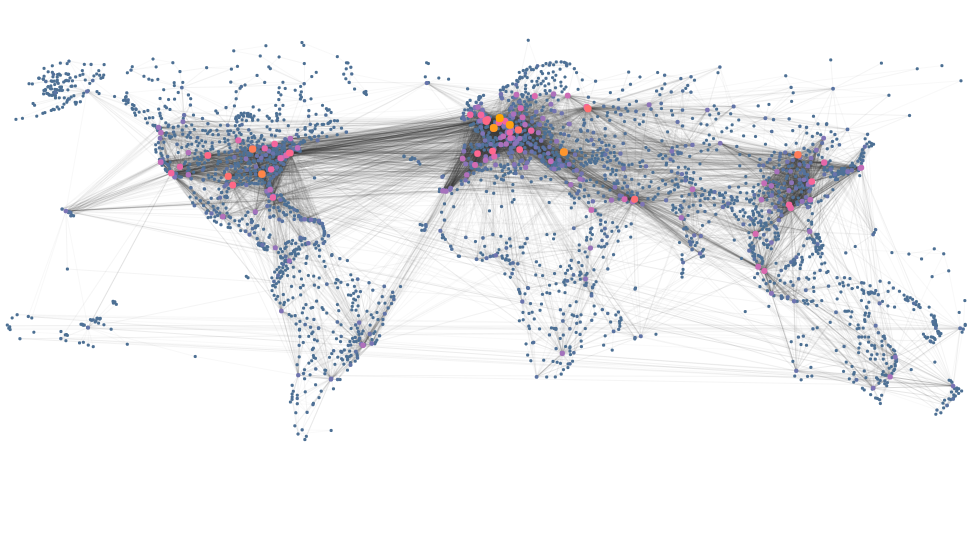

In [21]:
# normalise longitude / latitude; they don't have to be -1:1 or 0:1 range,
# however by default lat is -90:90 and long is -180:180, so we get them onto equivalent scales
pos_long_lat = {
    k: (
        np.interp(item["longitude"], [-180,180], [-1, 1]),
        np.interp(item["latitude"], [-90,90], [-1,1]),
    )
    for k, item in airports.set_index("airport_id").to_dict("index").items()
}
# creates {airport_id: (long, lat), ...} - e.g. {1: (145.391998291, -6.081689834590001), ...}

# optionally, sort nodes to ensure high centrality nodes are last, hence rendered over the top of others
def sort_graph_nodes_by_attr(G, attr_name, reverse=False):
    G_sorted = nx.Graph()
    
    G_sorted.add_nodes_from(sorted(
        G.nodes(data=True),
        key=lambda nd: nd[1][attr_name],
        reverse=reverse,
    ))
    G_sorted.add_edges_from(G.edges(data=True))
    
    return G_sorted

G_sorted = sort_graph_nodes_by_attr(G, "degree_centrality")
alph_call(G_sorted, layout_fn=lambda _: pos_long_lat)

In [9]:
alph_call(G_sorted)

alt.LayerChart(...)

In [22]:
# https://github.com/aekpalakorn/python-backbone-network/blob/master/backbone.py

from scipy import integrate

def disparity_filter_undirected(G, weight_attr='weight'):
    assert not G.is_directed()

    B = nx.Graph()
    for u in G:
        k = len(G[u])
        if k > 1:
            sum_w = sum(np.absolute(G[u][v][weight_attr]) for v in G[u])
            for v in G[u]:
                w = G[u][v][weight_attr]
                p_ij = float(np.absolute(w))/sum_w
                alpha_ij = 1 - (k-1) * integrate.quad(lambda x: (1-x)**(k-2), 0, p_ij)[0]
                B.add_edge(u, v, weight = w, alpha=float('%.4f' % alpha_ij))
    return B

In [23]:
G_df = disparity_filter_undirected(G_sorted)

alpha = 0.5
G_bb = G_sorted.copy()
G_bb.remove_edges_from([
    (u, v)
    for u, v, d in G_df.edges(data=True)
     if d.get("alpha", 1) < alpha # if no alpha, we need to prune
])
G_bb.remove_nodes_from(list(nx.isolates(G_bb)))

# recalc node centrality
nx.set_node_attributes(G_bb, nx.degree_centrality(G_bb), "degree_centrality")

print('backbone: nodes = %s, edges = %s' % (G_bb.number_of_nodes(), G_bb.number_of_edges()))

backbone: nodes = 2658, edges = 8240


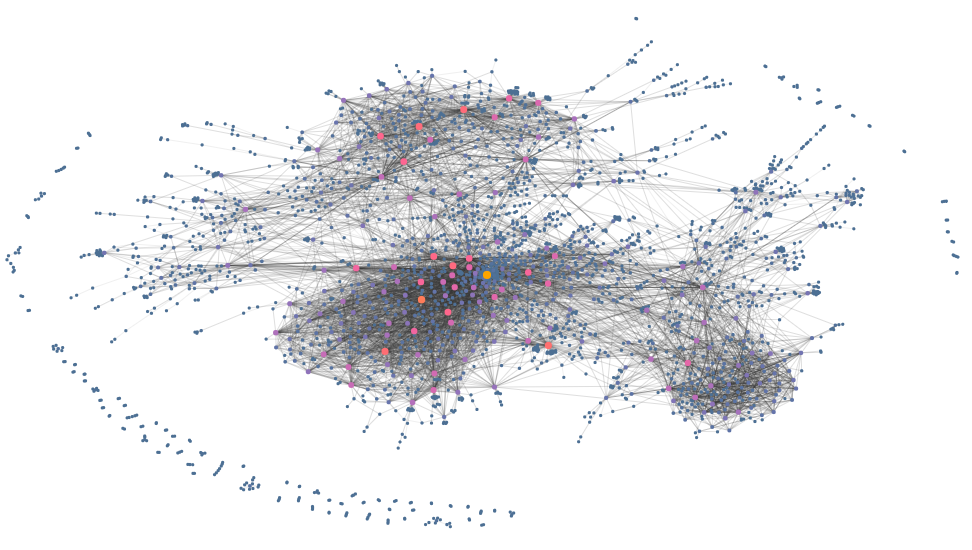

In [24]:
alph_call(G_bb)

In [28]:
min_weight_threshold = 5 # could use quantile, etc
edges_thr = [(u, v) for u, v, d in G_sorted.edges(data=True) if d["weight"] >= min_weight_threshold]
edges_mst = list(nx.maximum_spanning_edges(G_sorted, data=False))
edges_to_keep = list(set([*edges_thr, *edges_mst]))

G_mst = G_sorted.copy()
G_mst.remove_edges_from(
    [(u, v) for u, v in G_sorted.edges() if (u, v) not in edges_to_keep]
)
G_mst.remove_nodes_from(list(nx.isolates(G_mst)))

# recalc node centrality
nx.set_node_attributes(G_mst, nx.degree_centrality(G_mst), "degree_centrality")

print(f"nodes: {G_mst.number_of_nodes()}, edges: {G_mst.number_of_edges()}")

nodes: 3214, edges: 5728


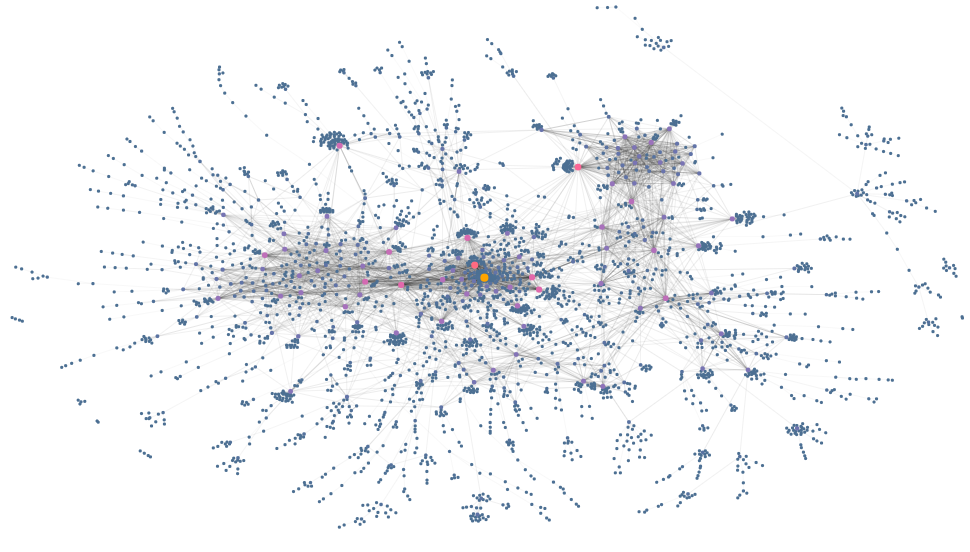

In [26]:
alph_call(G_mst)